In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [2]:
df=pd.read_csv('StudentPerformanceFactors.csv')
df.head(10)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70
5,19,88,Medium,Medium,Yes,8,89,Medium,Yes,3,Medium,Medium,Public,Positive,3,No,Postgraduate,Near,Male,71
6,29,84,Medium,Low,Yes,7,68,Low,Yes,1,Low,Medium,Private,Neutral,2,No,High School,Moderate,Male,67
7,25,78,Low,High,Yes,6,50,Medium,Yes,1,High,High,Public,Negative,2,No,High School,Far,Male,66
8,17,94,Medium,High,No,6,80,High,Yes,0,Medium,Low,Private,Neutral,1,No,College,Near,Male,69
9,23,98,Medium,Medium,Yes,8,71,Medium,Yes,0,High,High,Public,Positive,5,No,High School,Moderate,Male,72


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [4]:
df['Teacher_Quality'].unique()

array(['Medium', 'High', 'Low', nan], dtype=object)

In [5]:
df['Distance_from_Home'].unique()

array(['Near', 'Moderate', 'Far', nan], dtype=object)

In [6]:
def production_eda_report(df):
    print("=== 1. Target Variable Analysis (Exam_Score) ===")
    print(df['Exam_Score'].describe())
    
    print("\n=== 2. Categorical Feature Inspection ===")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        unique_vals = df[col].unique()
        print(f"Feature: {col}")
        print(f"  - Unique Count: {df[col].nunique()}")
        # Only print the values if there are less than 20, otherwise just show a sample
        if df[col].nunique() < 20:
            print(f"  - Values: {unique_vals}")
        else:
            print(f"  - Values (Sample): {unique_vals[:5]} ...")
            
    print("\n=== 3. Missing Data Deep Dive ===")
    missing_cols = ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']
    for col in missing_cols:
        if col in df.columns:
            # Compare the average exam score when the feature is missing vs present
            score_missing = df[df[col].isnull()]['Exam_Score'].mean()
            score_present = df[df[col].notnull()]['Exam_Score'].mean()
            print(f"Target mean when '{col}' is MISSING: {score_missing:.2f}")
            print(f"Target mean when '{col}' is PRESENT: {score_present:.2f}")


production_eda_report(df)

=== 1. Target Variable Analysis (Exam_Score) ===
count    6607.000000
mean       67.235659
std         3.890456
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       101.000000
Name: Exam_Score, dtype: float64

=== 2. Categorical Feature Inspection ===
Feature: Parental_Involvement
  - Unique Count: 3
  - Values: ['Low' 'Medium' 'High']
Feature: Access_to_Resources
  - Unique Count: 3
  - Values: ['High' 'Medium' 'Low']
Feature: Extracurricular_Activities
  - Unique Count: 2
  - Values: ['No' 'Yes']
Feature: Motivation_Level
  - Unique Count: 3
  - Values: ['Low' 'Medium' 'High']
Feature: Internet_Access
  - Unique Count: 2
  - Values: ['Yes' 'No']
Feature: Family_Income
  - Unique Count: 3
  - Values: ['Low' 'Medium' 'High']
Feature: Teacher_Quality
  - Unique Count: 3
  - Values: ['Medium' 'High' 'Low' nan]
Feature: School_Type
  - Unique Count: 2
  - Values: ['Public' 'Private']
Feature: Peer_Influence
  - Unique Count: 3
  - Values: ['Positiv

In [7]:
# 1. Handle the Target Anomaly (The 101 Score)
print(f"Original shape: {df.shape}")
df = df[df['Exam_Score'] <= 100].copy()
print(f"Shape after removing anomalies: {df.shape}")

# 2. Separate Features (X) and Target (y)
X = df.drop(columns=['Exam_Score'])
y = df['Exam_Score']

# 3. Train/Test Split BEFORE Pipeline Construction
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Define Feature Groups Based on our EDA
numeric_features = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 
                    'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity']

# For ordinal, we MUST define the exact order, otherwise it sorts alphabetically
ordinal_features = ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 
                    'Family_Income', 'Teacher_Quality', 'Parental_Education_Level', 
                    'Distance_from_Home', 'Peer_Influence']

ordinal_categories = [
    ['Low', 'Medium', 'High'], # Parental_Involvement
    ['Low', 'Medium', 'High'], # Access_to_Resources
    ['Low', 'Medium', 'High'], # Motivation_Level
    ['Low', 'Medium', 'High'], # Family_Income
    ['Low', 'Medium', 'High'], # Teacher_Quality
    ['High School', 'College', 'Postgraduate'], # Parental_Education_Level
    ['Near', 'Moderate', 'Far'], # Distance_from_Home
    ['Negative', 'Neutral', 'Positive'] # Peer_Influence
]

nominal_features = ['Extracurricular_Activities', 'Internet_Access', 
                    'School_Type', 'Learning_Disabilities', 'Gender']

# 5. Build Sub-Pipelines for Each Feature Type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) # Linear models need standardized inputs
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')) 
])

# 6. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('nom', nominal_transformer, nominal_features)
    ])

# 7. Create the Final End-to-End Pipeline
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 8. Train and Evaluate
print("\nTraining Baseline Linear Regression Model...")
baseline_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = baseline_pipeline.predict(X_train)
y_test_pred = baseline_pipeline.predict(X_test)

# Metrics
print("\n=== Baseline Model Performance ===")
print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred):.3f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_test_pred):.3f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.3f}")
print(f"Test RMSE:  {np.sqrt(mean_squared_error(y_test, y_test_pred)):.3f}")

Original shape: (6607, 20)
Shape after removing anomalies: (6606, 20)

Training Baseline Linear Regression Model...

=== Baseline Model Performance ===
Train MAE: 0.500
Test MAE:  0.410
Train RMSE: 2.110
Test RMSE:  1.518


In [8]:
# === 1. Cross-Validation ===
print("Running 5-Fold Cross Validation...")
cv_scores = cross_val_score(baseline_pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -cv_scores

print(f"CV MAE Scores across 5 folds: {cv_mae}")
print(f"Average CV MAE: {cv_mae.mean():.3f} (+/- {cv_mae.std() * 2:.3f})")

# === 2. Feature Importance (Interrogating the Model) ===
print("\nExtracting Feature Coefficients...")

# Extract the trained model and preprocessor from the pipeline
trained_model = baseline_pipeline.named_steps['regressor']
trained_preprocessor = baseline_pipeline.named_steps['preprocessor']

# Get feature names after transformation
try:
    feature_names = trained_preprocessor.get_feature_names_out()
    
    # Clean up the names (remove the 'num__', 'ord__', 'nom__' prefixes)
    clean_names = [name.split('__')[1] for name in feature_names]
    
    # Create a DataFrame of coefficients
    coefficients = pd.DataFrame({
        'Feature': clean_names,
        'Coefficient': trained_model.coef_
    })
    
    # Sort by absolute impact (highest magnitude first)
    coefficients['Abs_Impact'] = coefficients['Coefficient'].abs()
    coefficients = coefficients.sort_values(by='Abs_Impact', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(coefficients[['Feature', 'Coefficient']].head(10))
    
except Exception as e:
    print(f"Could not extract feature names automatically (likely older sklearn version). Error: {e}")

Running 5-Fold Cross Validation...
CV MAE Scores across 5 folds: [0.53826671 0.48030899 0.4832665  0.47275008 0.41139764]
Average CV MAE: 0.477 (+/- 0.081)

Extracting Feature Coefficients...

Top 10 Most Important Features:
                           Feature  Coefficient
1                       Attendance     2.284560
0                    Hours_Studied     1.742988
7              Access_to_Resources     1.046299
6             Parental_Involvement     1.015806
15             Internet_Access_Yes     0.947342
17       Learning_Disabilities_Yes    -0.885075
3                  Previous_Scores     0.703901
4                Tutoring_Sessions     0.595157
14  Extracurricular_Activities_Yes     0.550159
8                 Motivation_Level     0.540205


In [9]:
# 1. Create the Advanced Pipeline
# We reuse the exact same 'preprocessor' we built for the linear model!
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# 2. Define the Hyperparameter Grid
param_grid = {
    'xgb__n_estimators': [100, 300],             
    'xgb__max_depth': [3, 5],                    # Kept shallow to prevent overfitting
    'xgb__learning_rate': [0.01, 0.05, 0.1], 
    'xgb__subsample': [0.8, 1.0],                
    'xgb__colsample_bytree': [0.8, 1.0],         
    'xgb__reg_alpha': [0, 0.1, 1.0],             # L1 Regularization (forces useless features to 0)
    'xgb__reg_lambda': [1.0, 5.0, 10.0]          # L2 Regularization (shrinks extreme weights)
}

# 3. Configure the Grid Search
print("Starting XGBoost Hyperparameter Tuning (This may take a minute or two)...")
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    cv=5,                                    # 5-Fold Cross Validation
    scoring='neg_mean_absolute_error',
    n_jobs=-1,                               # Use all available CPU cores
    verbose=1
)

# 4. Train and Search
grid_search.fit(X_train, y_train)

# 5. Extract the best Model
best_xgb_model = grid_search.best_estimator_

# 6. Evaluate on the unseen Test Set
y_test_pred_xgb = best_xgb_model.predict(X_test)
xgb_test_mae = mean_absolute_error(y_test, y_test_pred_xgb)

print("\n=== XGBoost Challenger Results ===")
print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"XGBoost Test MAE: {xgb_test_mae:.3f}")

# Compare against our Linear Baseline Test MAE (0.410)
print(f"Linear Baseline Test MAE: 0.410")

Starting XGBoost Hyperparameter Tuning (This may take a minute or two)...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

=== XGBoost Challenger Results ===
Best Parameters Found: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 300, 'xgb__reg_alpha': 1.0, 'xgb__reg_lambda': 10.0, 'xgb__subsample': 0.8}
XGBoost Test MAE: 0.600
Linear Baseline Test MAE: 0.410


C:\Users\nafay\AppData\Local\Temp\ipykernel_15140\669281241.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=test_analysis_df, x='Family_Income', y='Residual', ax=axes[2], palette='Set2')


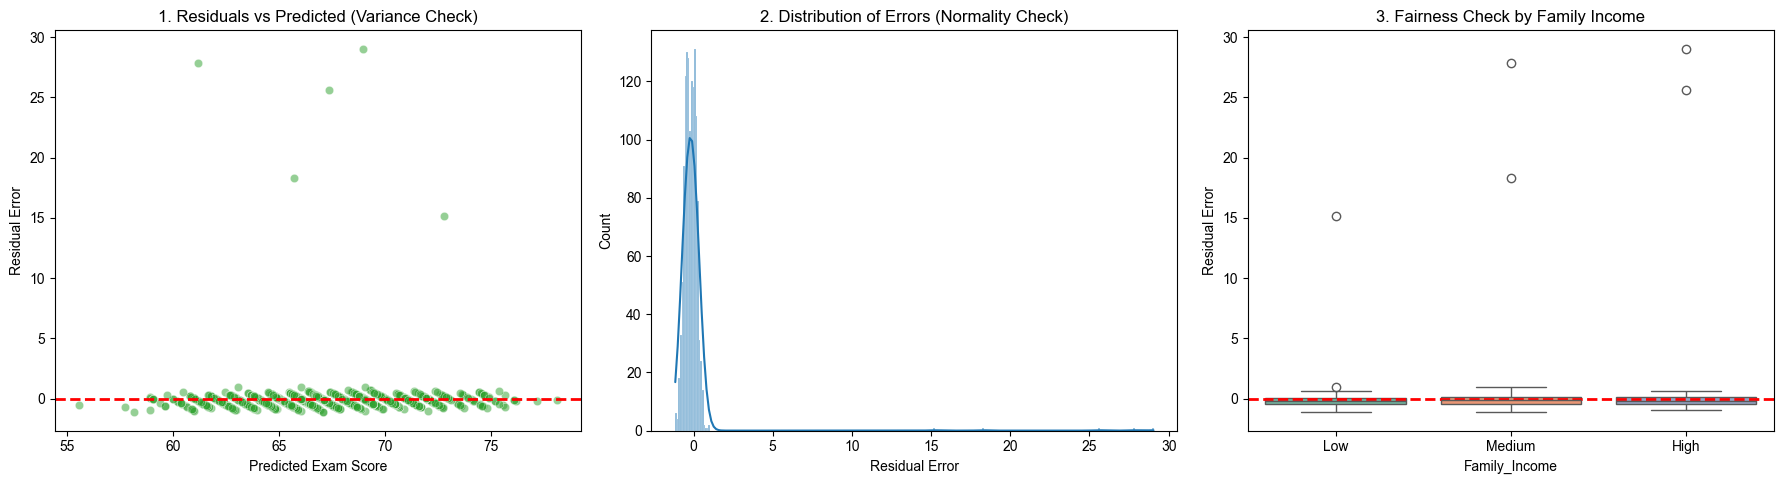

=== Algorithmic Fairness Audit: Mean Residuals ===

By Family Income:
Family_Income
High      0.0510
Low      -0.1694
Medium   -0.0859
Name: Residual, dtype: float64

By School Type:
School_Type
Private   -0.1562
Public    -0.0678
Name: Residual, dtype: float64

By Gender:
Gender
Female   -0.0468
Male     -0.1341
Name: Residual, dtype: float64


In [10]:
residuals = y_test - y_test_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.set_theme(style="whitegrid")

# --- PLOT 1: Residuals vs. Predicted (The Variance Check) ---
sns.scatterplot(x=y_test_pred, y=residuals, ax=axes[0], alpha=0.5, color='#2ca02c')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('1. Residuals vs Predicted (Variance Check)')
axes[0].set_xlabel('Predicted Exam Score')
axes[0].set_ylabel('Residual Error')

# --- PLOT 2: Distribution of Residuals (The Normality Check) ---
sns.histplot(residuals, kde=True, ax=axes[1], color='#1f77b4')
axes[1].set_title('2. Distribution of Errors (Normality Check)')
axes[1].set_xlabel('Residual Error')

# --- PLOT 3: Fairness Check by a Key Demographic ---
# We temporarily attach our residuals back to the test features 
# so we can group them by categories like Family Income or School Type.
test_analysis_df = X_test.copy()
test_analysis_df['Residual'] = residuals

# You can swap 'Family_Income' for 'School_Type' or 'Gender' to check other groups
sns.boxplot(data=test_analysis_df, x='Family_Income', y='Residual', ax=axes[2], palette='Set2')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[2].set_title('3. Fairness Check by Family Income')
axes[2].set_ylabel('Residual Error')

plt.tight_layout()
plt.show()

# 3. Print the Hard Numbers for Compliance Documentation
print("=== Algorithmic Fairness Audit: Mean Residuals ===")
print("\nBy Family Income:")
print(test_analysis_df.groupby('Family_Income')['Residual'].mean().round(4))

print("\nBy School Type:")
print(test_analysis_df.groupby('School_Type')['Residual'].mean().round(4))

print("\nBy Gender:")
print(test_analysis_df.groupby('Gender')['Residual'].mean().round(4))

In [13]:
# 1. Attach the true Exam_Score (from y_test) back to our analysis dataframe
test_analysis_df['Actual_Exam_Score'] = y_test

# 2. Isolate the extreme outliers (Residual > 10 means we under-predicted by more than 10 points)
anomalies = test_analysis_df[test_analysis_df['Residual'] > 10].sort_values(by='Residual', ascending=False)

print(f"Found {len(anomalies)} extreme outliers.")

# 3. Display the features of the worst 5 offenders
display(anomalies[['Actual_Exam_Score', 'Residual', 'Hours_Studied', 'Attendance', 'Previous_Scores']].head(5))

Found 5 extreme outliers.


,Actual_Exam_Score,Residual,Hours_Studied,Attendance,Previous_Scores
6393,98,29.042018,16,83,92
217,89,27.811835,19,70,54
4583,93,25.629052,25,73,56
3932,84,18.278813,25,66,55
1607,88,15.180764,30,98,93


In [15]:
# 1. Generate predictions for both train and test sets
y_train_pred = baseline_pipeline.predict(X_train)
y_test_pred = baseline_pipeline.predict(X_test)

# 2. Calculate R-squared (Variance Explained)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# 3. Calculate MAPE (Mean Absolute Percentage Error)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

# 4. The Final Printout
print("=== Final Production Metrics Dashboard ===")
print(f"R-squared (Train): {r2_train:.4f} (Explains {r2_train*100:.2f}% of the variance)")
print(f"R-squared (Test):  {r2_test:.4f} (Explains {r2_test*100:.2f}% of the variance)")
print("-" * 40)
print(f"MAPE (Train):      {mape_train:.4f} (Average error is {mape_train*100:.2f}%)")
print(f"MAPE (Test):       {mape_test:.4f} (Average error is {mape_test*100:.2f}%)")
print("-" * 40)
print(f"MAE (Test):        {mean_absolute_error(y_test, y_test_pred):.3f} exam points")
print(f"RMSE (Test):       {np.sqrt(mean_squared_error(y_test, y_test_pred)):.3f} exam points")

=== Final Production Metrics Dashboard ===
R-squared (Train): 0.7107 (Explains 71.07% of the variance)
R-squared (Test):  0.8258 (Explains 82.58% of the variance)
----------------------------------------
MAPE (Train):      0.0068 (Average error is 0.68%)
MAPE (Test):       0.0058 (Average error is 0.58%)
----------------------------------------
MAE (Test):        0.410 exam points
RMSE (Test):       1.518 exam points


In [17]:
# 1. Create the Robust Pipeline
robust_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),

    ('regressor', HuberRegressor(epsilon=1.35, max_iter=2000)) 
])

# 2. Train the Robust Model
print("Training Huber Regressor")
robust_pipeline.fit(X_train, y_train)

# 3. Generate Predictions
y_train_pred_robust = robust_pipeline.predict(X_train)
y_test_pred_robust = robust_pipeline.predict(X_test)

# 4. Calculate the Final Metrics
r2_train_robust = r2_score(y_train, y_train_pred_robust)
r2_test_robust = r2_score(y_test, y_test_pred_robust)
mape_train_robust = mean_absolute_percentage_error(y_train, y_train_pred_robust)
mape_test_robust = mean_absolute_percentage_error(y_test, y_test_pred_robust)
mae_test_robust = mean_absolute_error(y_test, y_test_pred_robust)
rmse_test_robust = np.sqrt(mean_squared_error(y_test, y_test_pred_robust))

# 5. Display the Final Results
print("\n=== Robust Production Metrics Dashboard (Huber) ===")
print(f"R-squared (Train): {r2_train_robust:.4f}")
print(f"R-squared (Test):  {r2_test_robust:.4f}")
print("-" * 40)
print(f"MAPE (Train):      {mape_train_robust:.4f}")
print(f"MAPE (Test):       {mape_test_robust:.4f}")
print("-" * 40)
print(f"MAE (Test):        {mae_test_robust:.3f} exam points")
print(f"RMSE (Test):       {rmse_test_robust:.3f} exam points")

Training Huber Regressor

=== Robust Production Metrics Dashboard (Huber) ===
R-squared (Train): 0.7077
R-squared (Test):  0.8269
----------------------------------------
MAPE (Train):      0.0061
MAPE (Test):       0.0052
----------------------------------------
MAE (Test):        0.372 exam points
RMSE (Test):       1.513 exam points


In [18]:
# 1. Define the Hyperparameter Grid for Huber
huber_param_grid = {
    # Testing stricter (1.1) to more relaxed (2.0) outlier thresholds
    'regressor__epsilon': [1.1, 1.2, 1.35, 1.5, 1.75, 2.0],
    # Testing tiny to heavy L2 regularization penalties
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

# 2. Configure the Grid Search
print("Starting Huber Hyperparameter Tuning (Grid Search)...")
huber_grid_search = GridSearchCV(
    estimator=robust_pipeline, # We reuse our existing pipeline!
    param_grid=huber_param_grid,
    cv=5,                      # 5-fold cross validation
    scoring='neg_mean_absolute_error',
    n_jobs=-1,                 # Use all CPU cores
    verbose=1
)

# 3. Train and Search
huber_grid_search.fit(X_train, y_train)

# 4. Extract the Absolute Champion Model
best_huber_model = huber_grid_search.best_estimator_

# 5. Evaluate on the Unseen Test Set
y_test_pred_best = best_huber_model.predict(X_test)

best_mae = mean_absolute_error(y_test, y_test_pred_best)
best_r2 = r2_score(y_test, y_test_pred_best)

# 6. The Final Results
print("\n=== Tuned Huber Regressor Results ===")
print(f"Best Parameters Found: {huber_grid_search.best_params_}")
print("-" * 40)
print(f"Previous Default Huber MAE: {mae_test_robust:.4f}")
print(f"Newly Tuned Huber MAE:      {best_mae:.4f}")
print(f"Tuned Test R-squared:       {best_r2:.4f}")

Starting Huber Hyperparameter Tuning (Grid Search)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

=== Tuned Huber Regressor Results ===
Best Parameters Found: {'regressor__alpha': 1.0, 'regressor__epsilon': 2.0}
----------------------------------------
Previous Default Huber MAE: 0.3717
Newly Tuned Huber MAE:      0.3716
Tuned Test R-squared:       0.8269


In [20]:
ultimate_production_model = huber_grid_search.best_estimator_

model_filename = 'ultimate_student_huber_pipeline.pkl'
joblib.dump(ultimate_production_model, model_filename)

print(f"=== SUCCESS ===")
print(f"Model saved successfully as: {model_filename}")
print("This file contains the full preprocessing and tuned Huber Regressor.")
print("It is completely ready for Streamlit deployment.")

=== SUCCESS ===
Model saved successfully as: ultimate_student_huber_pipeline.pkl
This file contains the full preprocessing and tuned Huber Regressor.
It is completely ready for Streamlit deployment.
